# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data** so that it is accepted by Keras


## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [1]:
import os
import warnings

import numpy

warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA/MPS is available (for GPU usage)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [3]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    
    
    df['z-axis'] = pd.to_numeric(df['z-axis'], errors='coerce')
    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    # Transform 'z-axis' column to float
    # df['z-axis'] = df['z-axis'].apply(convert_to_float)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

1.   List item
2.   List item

Then 'file_path' the directory to where you have put the data.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = '../data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [5]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


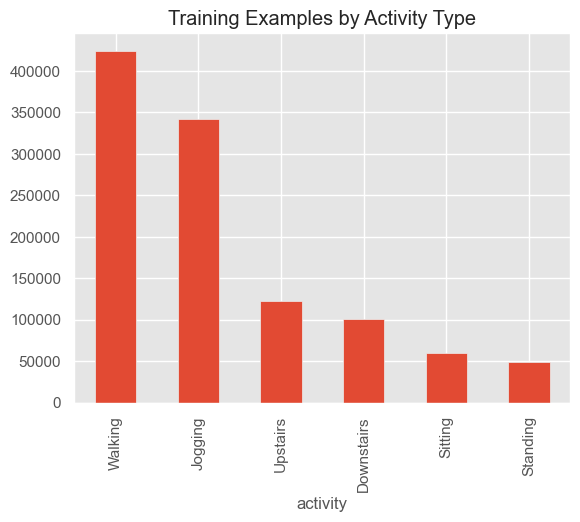

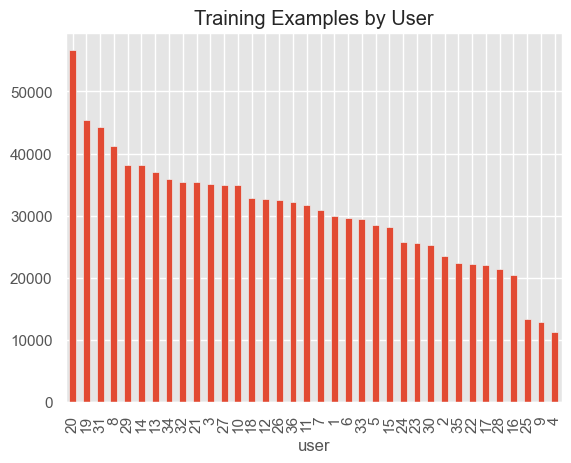

In [7]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

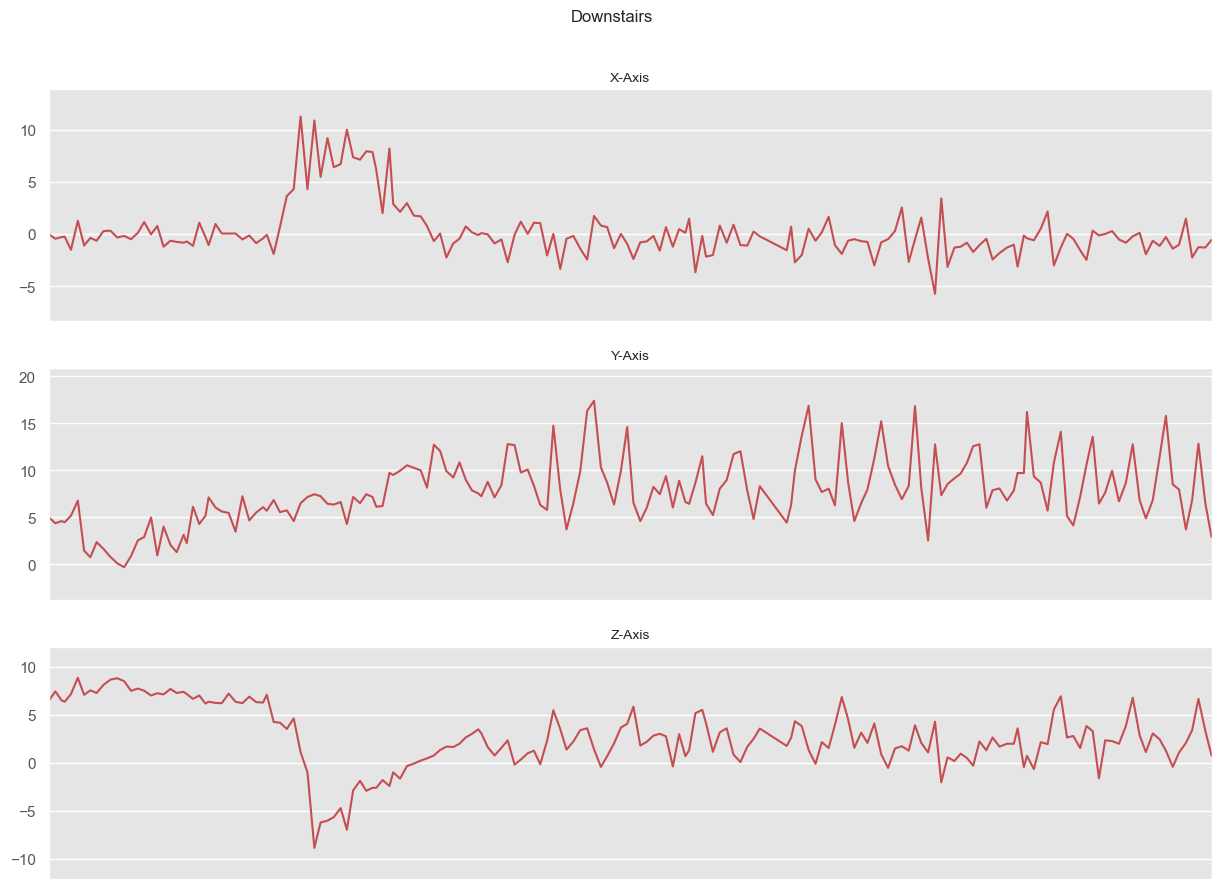

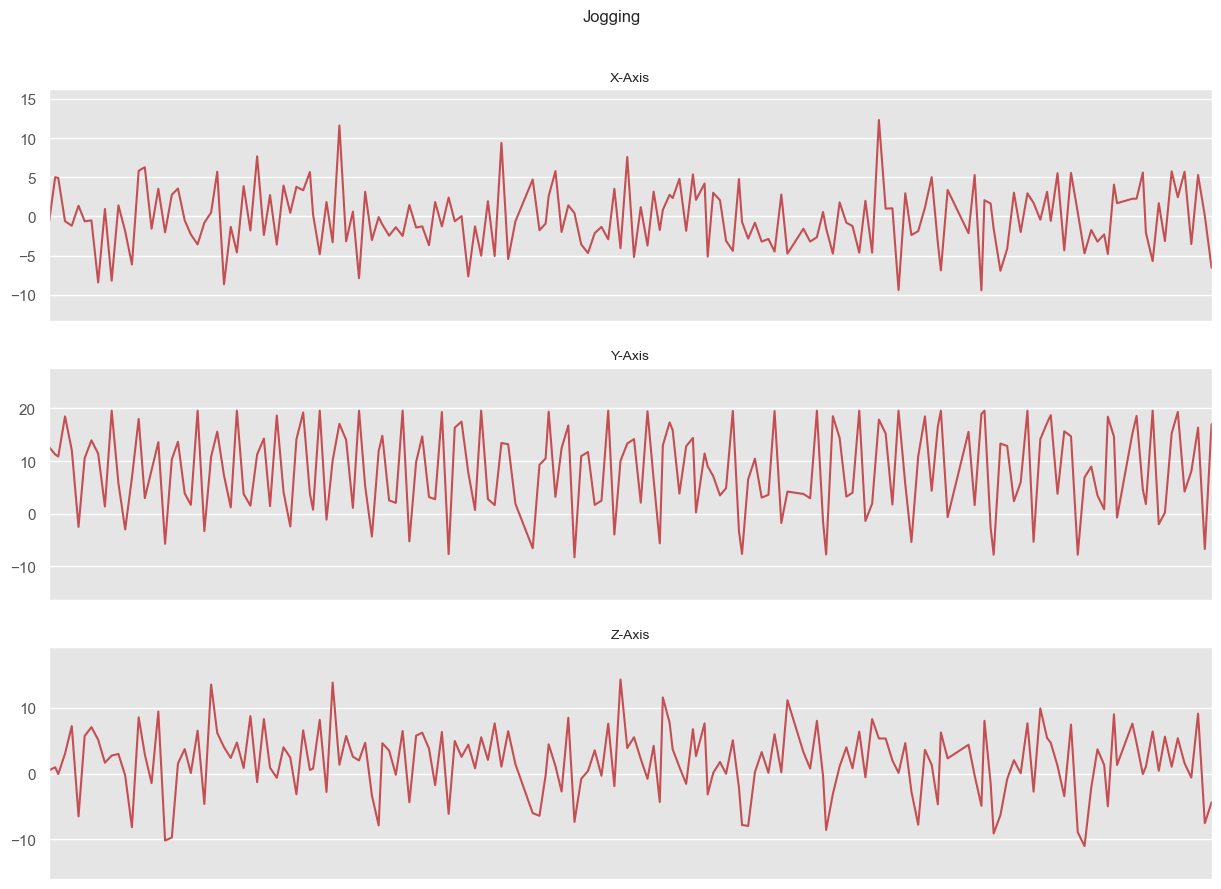

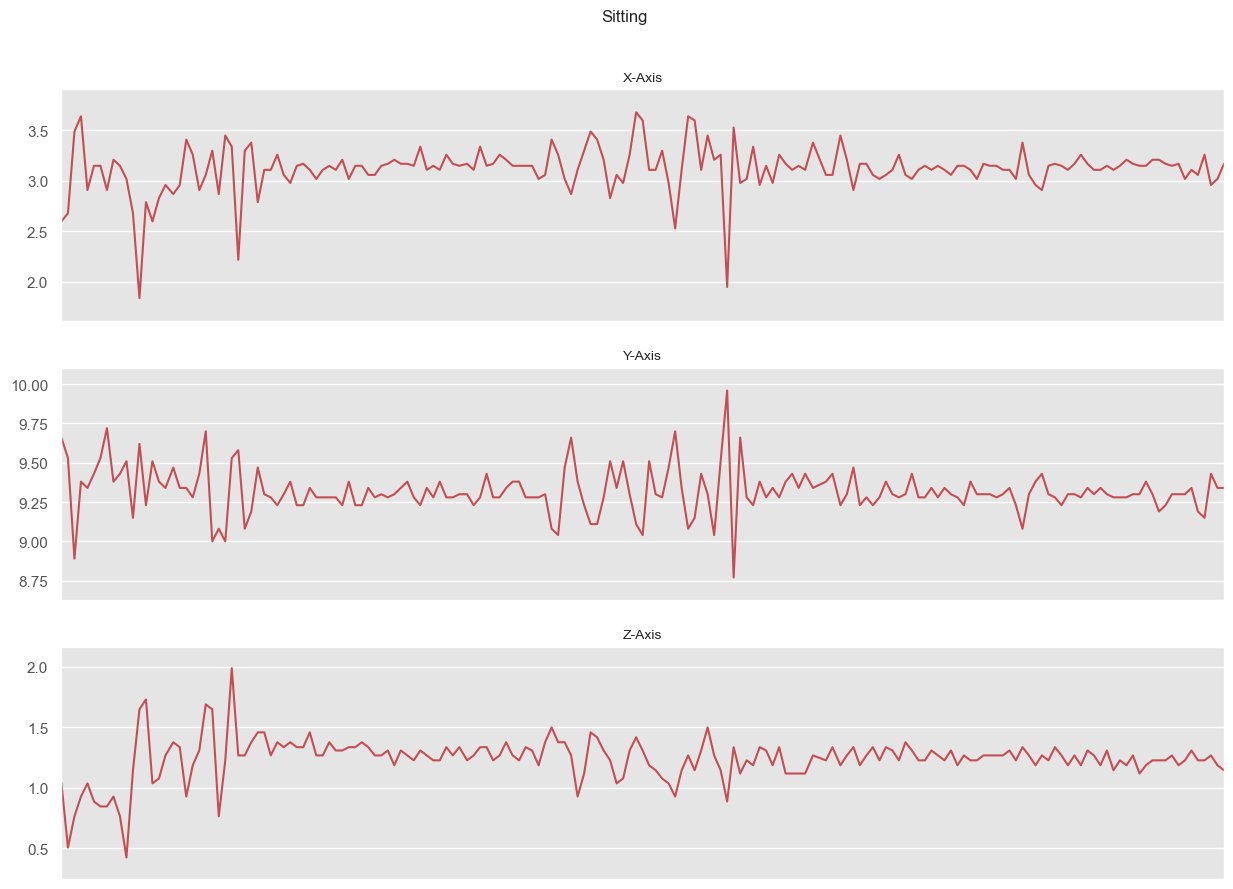

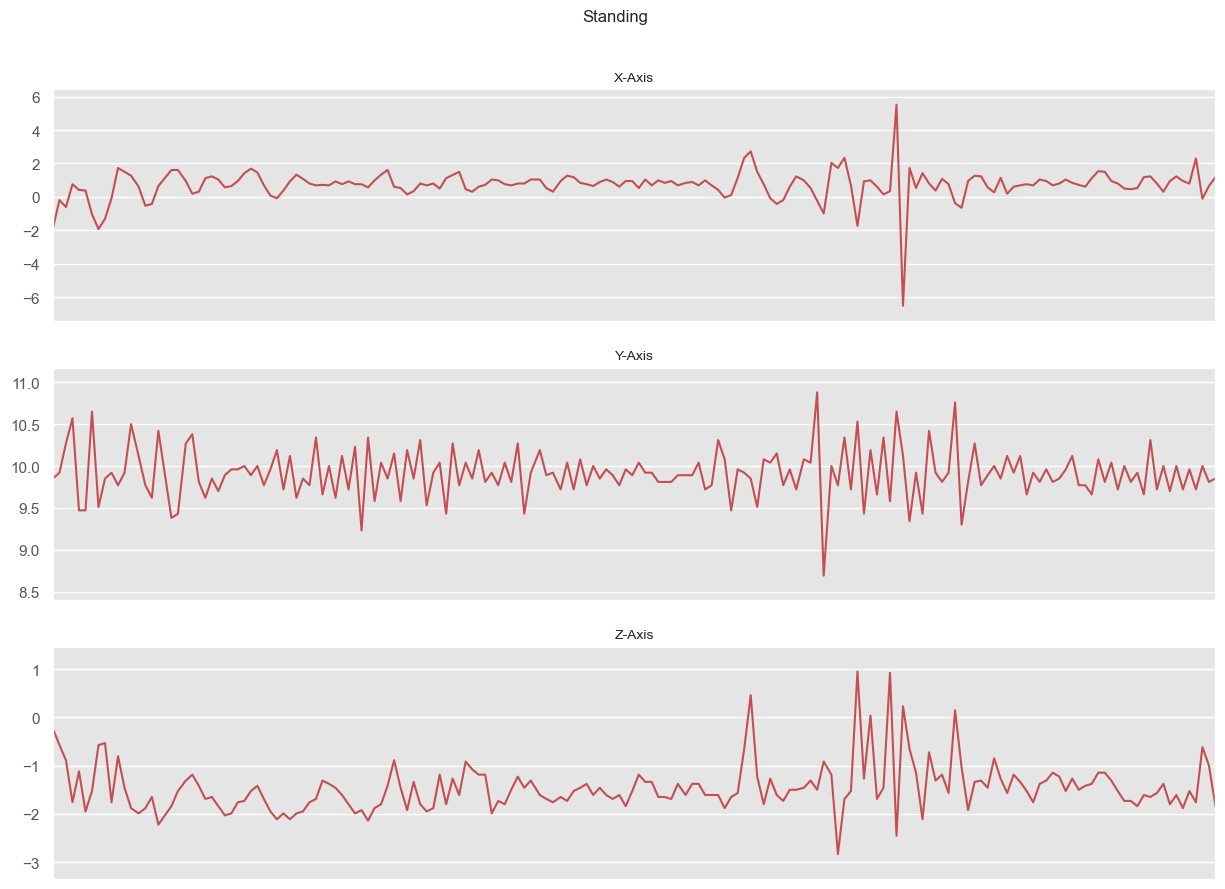

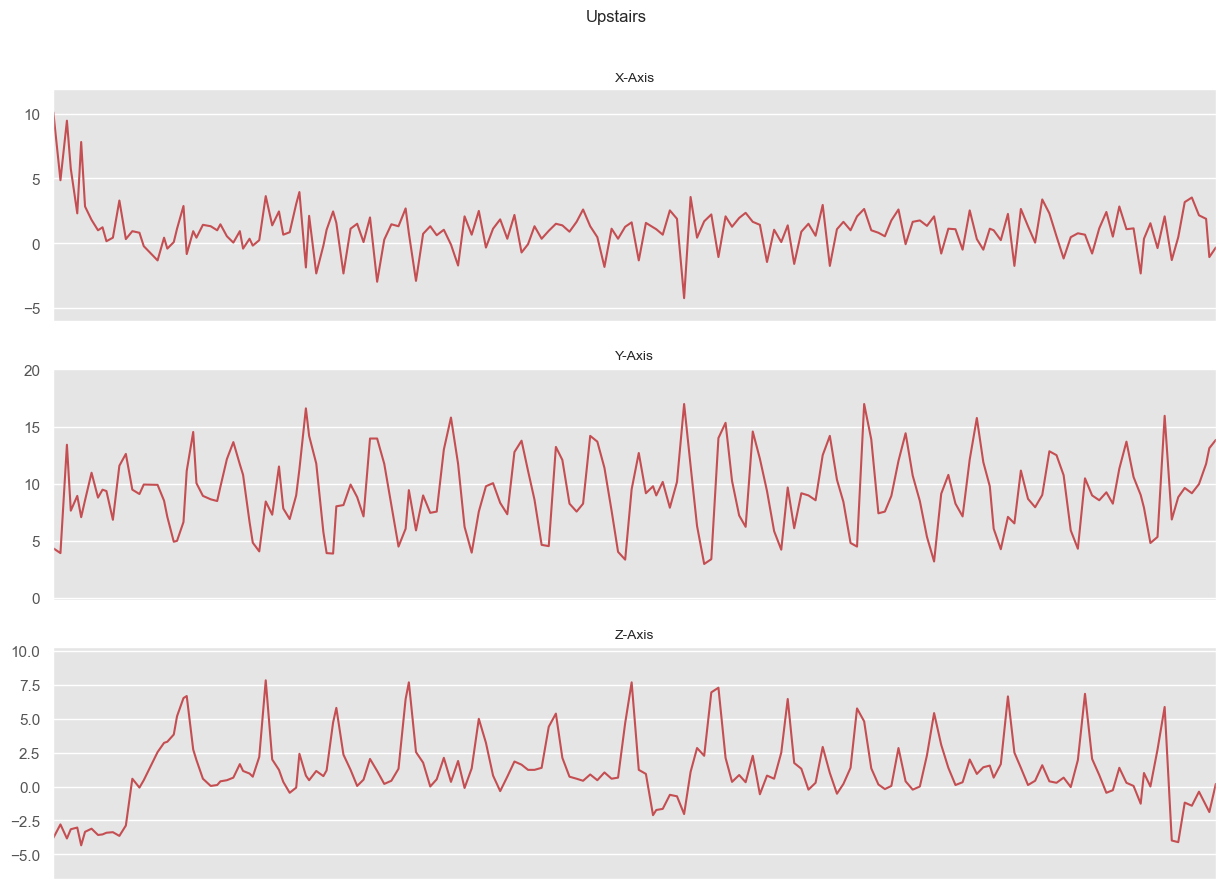

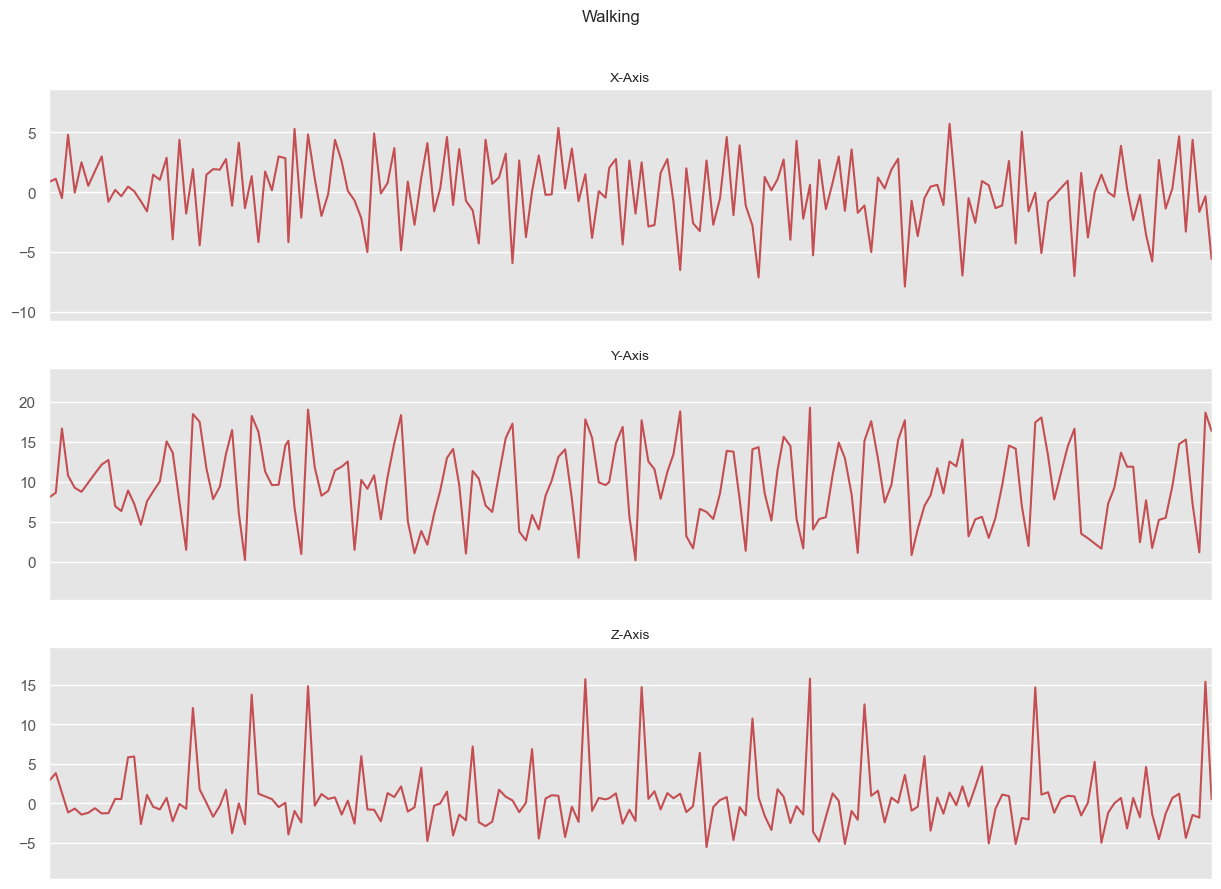

In [8]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [9]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [10]:
# Split data into train and test set
# train/validation: user 1 ~ 28
# test: user 28 ~

from sklearn.model_selection import train_test_split

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

print(df_train.shape)
print(df_validate.shape)
print(df_test.shape)

(834784, 7)
(107862, 7)
(120056, 7)


In [11]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

df_train.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshpae it.

In [12]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [13]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [14]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

print('x_validate shape: ', x_validate.shape)
print(x_validate.shape[0], 'validation samples')
print('y_validate shape: ', y_validate.shape)

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
x_validate shape:  (2695, 80, 3)
2695 validation samples
y_validate shape:  (2695,)
x_test shape:  (3000, 80, 3)
3000 test samples
y_test shape:  (3000,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [15]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [16]:
input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('x_validate shape:', x_validate.shape)
print('x_test shape:', x_test.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
x_validate shape: (2695, 240)
x_test shape: (3000, 240)
input shape: 240


In [17]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [18]:
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


In PyTorch, we need to wrap these NumPy arrays into a dataset and then create a DataLoader for batch processing.

In [19]:
# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron

## Base MLP

In [20]:
# Multi-layer Perceptron
class MLP(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.013073 	Accuracy: 70.82%
Validation: Average loss: 0.0145, Accuracy: 1766/2695 (65.53%)
Train Epoch: 2 	Loss: 0.006954 	Accuracy: 82.98%
Validation: Average loss: 0.0171, Accuracy: 1869/2695 (69.35%)
Train Epoch: 3 	Loss: 0.005410 	Accuracy: 86.56%
Validation: Average loss: 0.0203, Accuracy: 1859/2695 (68.98%)
Train Epoch: 4 	Loss: 0.004685 	Accuracy: 88.34%
Validation: Average loss: 0.0221, Accuracy: 1792/2695 (66.49%)
Train Epoch: 5 	Loss: 0.004028 	Accuracy: 89.89%
Validation: Average loss: 0.0166, Accuracy: 1957/2695 (72.62%)
Train Epoch: 6 	Loss: 0.003656 	Accuracy: 90.97%
Validation: Average loss: 0.0225, Accuracy: 1907/2695 (70.76%)
Train Epoch: 7 	Loss: 0.00327

Accuracy on val data:  77.73654916512059
Loss on val data:  0.09260834756540551


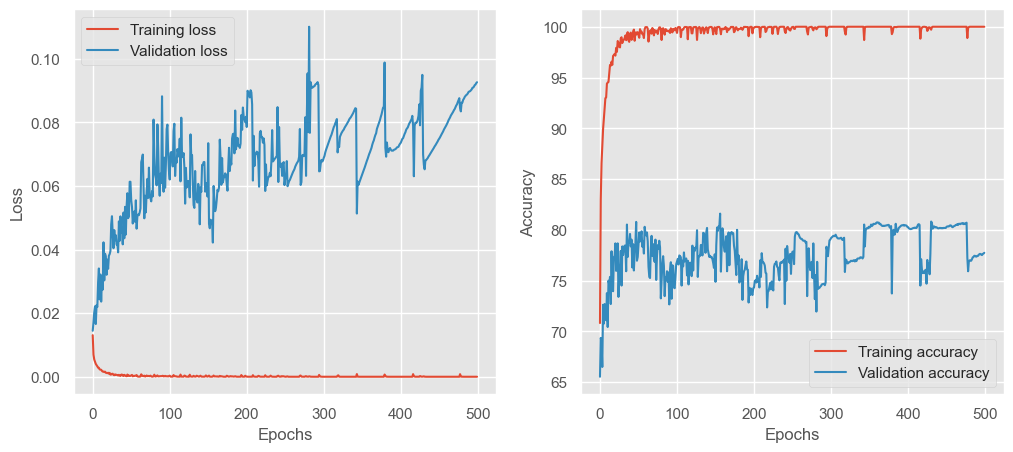

In [21]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

Result from the article

![Expectation](attachment:16797bb4-c2ae-4f1b-8a7a-e195e39da9c3.png)

## Configuration 1: Increase the Number of Hidden Layers and Use Sigmoid Activation

In [23]:
# Multi-layer Perceptron
class MLP_Config1(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 150)
        self.fc2 = nn.Linear(150, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 25)
        self.fc5 = nn.Linear(25, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config1(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.0005)

BATCH_SIZE = 400
EPOCHS = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=25, bias=True)
  (fc5): Linear(in_features=25, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.023513 	Accuracy: 38.80%
Validation: Average loss: 0.0257, Accuracy: 1212/2695 (44.97%)
Train Epoch: 2 	Loss: 0.021100 	Accuracy: 52.52%
Validation: Average loss: 0.0260, Accuracy: 1062/2695 (39.41%)
Train Epoch: 3 	Loss: 0.018480 	Accuracy: 60.05%
Validation: Average loss: 0.0240, Accuracy: 1267/2695 (47.01%)
Train Epoch: 4 	Loss: 0.016014 	Accuracy: 68.02%
Validation: Average loss: 0.0233, Accuracy: 1454/2695 (53.95%)
Train Epoch: 5 	Loss: 0.014343 	Accuracy: 71.95%
Validation: Average loss: 0.0229, Accuracy: 1509/2695 (55.99%)
Train Epoch: 6 	Loss: 0.013468 	Accuracy: 73.59%
Validation: Average loss: 

Accuracy on val data:  68.94248608534323
Loss on val data:  0.01920131442493922


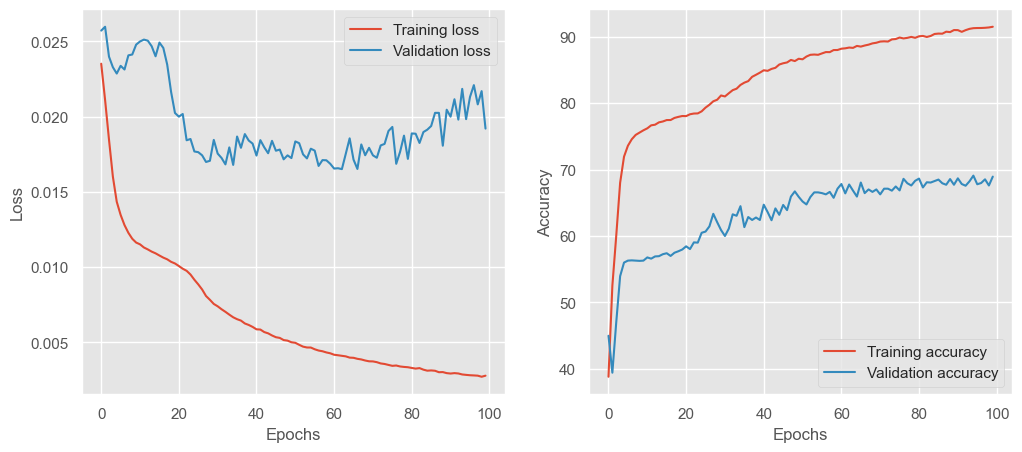

In [24]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 2: Reduce the Number of Hidden Layers and Use Tanh Activation

In [25]:
# Multi-layer Perceptron
class MLP_Config2(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config2(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

BATCH_SIZE = 200
EPOCHS = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.018331 	Accuracy: 58.90%
Validation: Average loss: 0.0233, Accuracy: 1452/2695 (53.88%)
Train Epoch: 2 	Loss: 0.012980 	Accuracy: 73.59%
Validation: Average loss: 0.0290, Accuracy: 1518/2695 (56.33%)
Train Epoch: 3 	Loss: 0.011641 	Accuracy: 75.37%
Validation: Average loss: 0.0302, Accuracy: 1525/2695 (56.59%)
Train Epoch: 4 	Loss: 0.011042 	Accuracy: 76.21%
Validation: Average loss: 0.0298, Accuracy: 1540/2695 (57.14%)
Train Epoch: 5 	Loss: 0.010358 	Accuracy: 77.21%
Validation: Average loss: 0.0304, Accuracy: 1541/2695 (57.18%)
Train Epoch: 6 	Loss: 0.009586 	Accuracy: 78.30%
Validation: Average loss: 0.0287, Accuracy: 1572/2695 (58.33%)
Train Epoch: 7 	Loss: 0.008622 	Accuracy: 79.36%
Validation: Average loss: 0.0267, Ac

Accuracy on val data:  70.57513914656772
Loss on val data:  0.052623281695640844


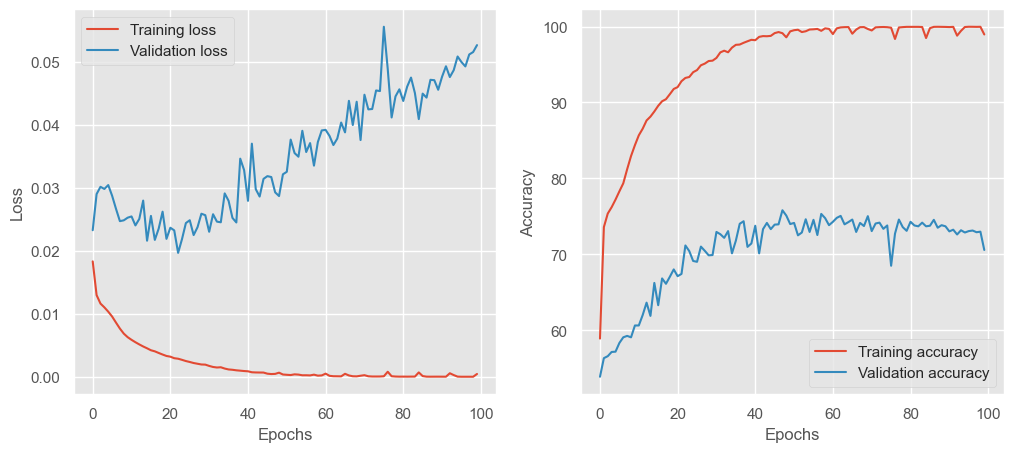

In [26]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 3: Use ReLU Activation and Adjust Learning Rate

In [27]:
# Multi-layer Perceptron
class MLP_Config3(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 120)
        self.fc2 = nn.Linear(150, 150)
        self.fc3 = nn.Linear(150, 200)
        self.fc4 = nn.Linear(200, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config2(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.002)

BATCH_SIZE = 400
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.016587 	Accuracy: 63.74%
Validation: Average loss: 0.0277, Accuracy: 1516/2695 (56.25%)
Train Epoch: 2 	Loss: 0.011737 	Accuracy: 74.97%
Validation: Average loss: 0.0247, Accuracy: 1540/2695 (57.14%)
Train Epoch: 3 	Loss: 0.010678 	Accuracy: 77.01%
Validation: Average loss: 0.0239, Accuracy: 1566/2695 (58.11%)
Train Epoch: 4 	Loss: 0.009814 	Accuracy: 78.07%
Validation: Average loss: 0.0230, Accuracy: 1565/2695 (58.07%)
Train Epoch: 5 	Loss: 0.008437 	Accuracy: 80.07%
Validation: Average loss: 0.0239, Accuracy: 1578/2695 (58.55%)
Train Epoch: 6 	Loss: 0.006686 	Accuracy: 83.87%
Validation: Average loss: 0.0237, Accuracy: 1632/2695 (60.56%)
Train Epoch: 7 	Loss: 0.005711 	Accuracy: 86.12%
Validation: Average loss: 0.0208, Ac

Accuracy on val data:  72.46753246753246
Loss on val data:  0.05070688839891983


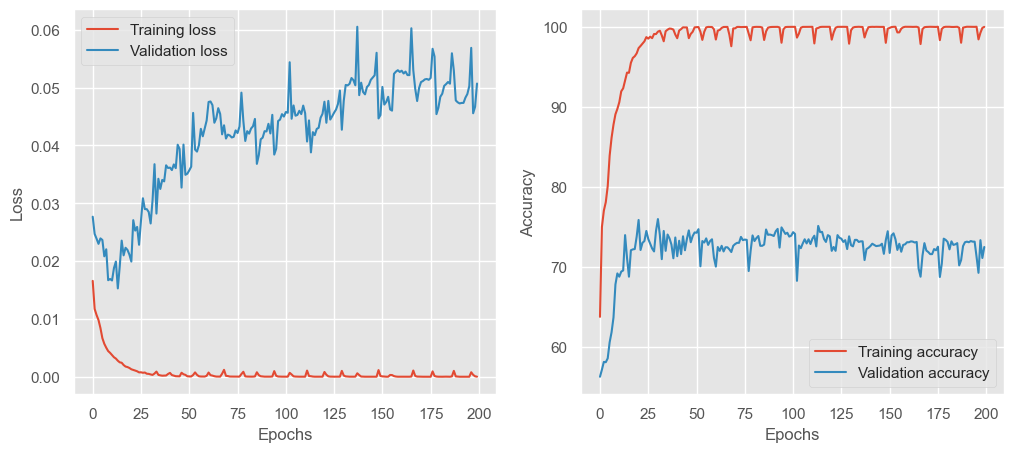

In [28]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Test

[[133   0   9  46  84  16]
 [ 87 747   0   0 149  26]
 [  0   0 223   0   0   0]
 [  1   0   1 113  34   0]
 [ 52   0   4   8 196  29]
 [183   5   0   2 121 731]]


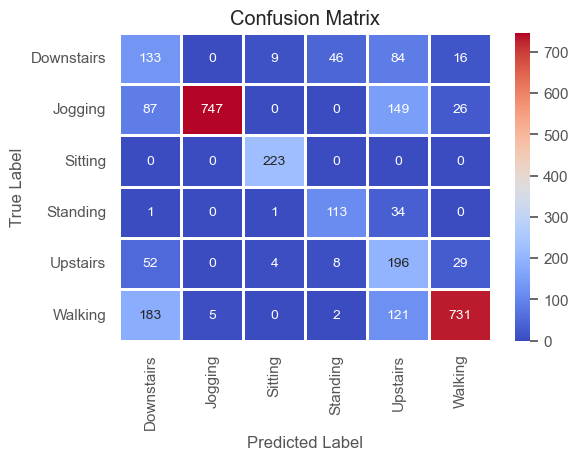

              precision    recall  f1-score   support

           0       0.29      0.46      0.36       288
           1       0.99      0.74      0.85      1009
           2       0.94      1.00      0.97       223
           3       0.67      0.76      0.71       149
           4       0.34      0.68      0.45       289
           5       0.91      0.70      0.79      1042

    accuracy                           0.71      3000
   macro avg       0.69      0.72      0.69      3000
weighted avg       0.81      0.71      0.75      3000


In [43]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_mlp.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


In [ ]:
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers

        # Pooling and dropout

        # Adaptive pool layer to adjust the size before sending to fully connected layer

        # Fully connected layer
        raise NotImplementedError

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)

        # Convolutional layers with ReLU activations

        # Global average pooling and dropout

        # Flatten the tensor for the fully connected layer

        # Output layer with softmax activation

        # output the loss, Use log_softmax for numerical stability
        raise NotImplementedError

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

In [ ]:
BATCH_SIZE = 400
EPOCHS = 200

# Optimizer
my_optimizer = None
best_val_loss = float('inf')
patience = 100
trigger_times = 0

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_cnn(model, device, num_epochs, my_optimizer):
    # Initialize lists to store losses and accuracies

    return train_losses, val_losses, train_accs, val_accs

def validate_cnn(model, device):
    raise NotImplementedError

    total = len(test_loader.dataset)
    val_acc = 100 * correct / total
    val_losses.append(running_loss / len(test_loader))
    val_accs.append(val_acc)

In [30]:
# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    validate(model_cnn, device, test_loader)

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.009328 	Accuracy: 77.97%
Validation: Average loss: 0.0083, Accuracy: 2557/3000 (85.23%)
Train Epoch: 2 	Loss: 0.003756 	Accuracy: 90.91%
Validation: Average loss: 0.0087, Accuracy: 2417/3000 (80.57%)
Train Epoch: 3 	Loss: 0.002241 	Accuracy: 95.39%
Validation: Average loss: 0.0098, Accuracy: 2492/3000 (83.07%)
Train Epoch: 4 	Loss: 0.001588 	Accuracy: 96.97%
Validation: Average loss: 0.0078, Accuracy: 2618/3000 (87.27%)
Train Epoch: 5 	Loss: 0.001332 	Accuracy: 97.63%
Validation: Aver

In [36]:
# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008755 	Accuracy: 78.94%
Validation: Average loss: 0.0063, Accuracy: 2563/3000 (85.43%)
Train Epoch: 2 	Loss: 0.003777 	Accuracy: 90.89%
Validation: Average loss: 0.0072, Accuracy: 2522/3000 (84.07%)
Train Epoch: 3 	Loss: 0.002517 	Accuracy: 94.43%
Validation: Average loss: 0.0074, Accuracy: 2533/3000 (84.43%)
Train Epoch: 4 	Loss: 0.001769 	Accuracy: 96.54%
Validation: Average loss: 0.0087, Accuracy: 2594/3000 (86.47%)
Train Epoch: 5 	Loss: 0.001441 	Accuracy: 97.29%
Validation: Aver

Accuracy on val data:  89.13333333333334
Loss on val data:  0.011212341390369751


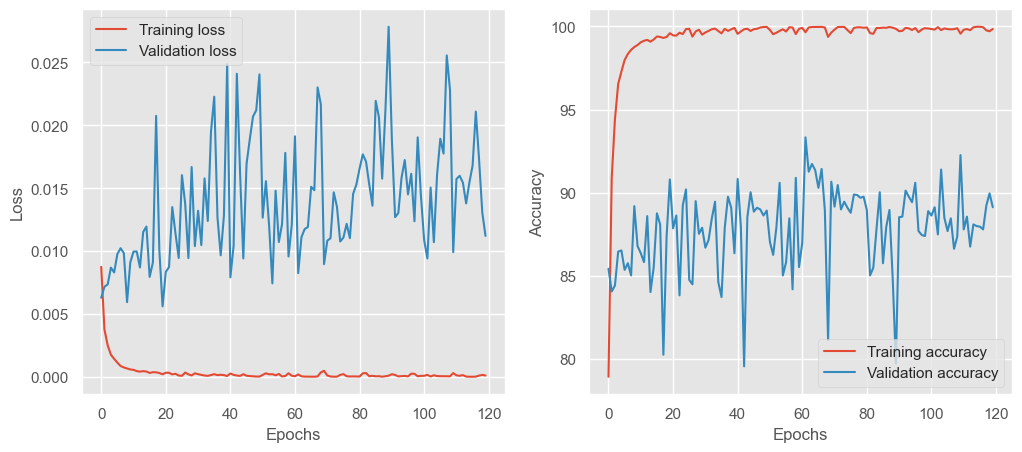

In [37]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Test

[[261   0   1   0  25   1]
 [ 13 960   0   0  23  13]
 [  0   0 223   0   0   0]
 [  0   0   0 147   2   0]
 [ 77   2   2   1 207   0]
 [ 16  28   0   0 122 876]]


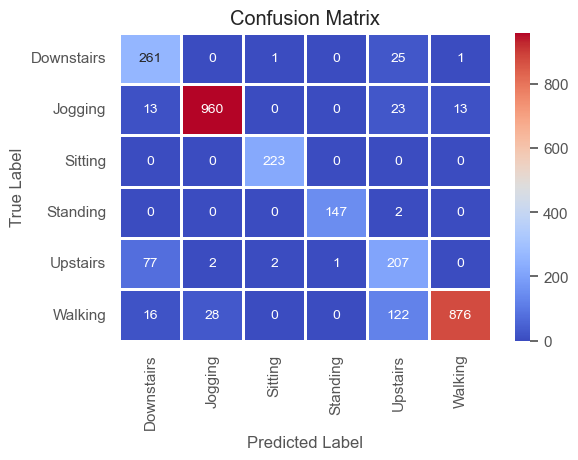

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       288
           1       0.97      0.95      0.96      1009
           2       0.99      1.00      0.99       223
           3       0.99      0.99      0.99       149
           4       0.55      0.72      0.62       289
           5       0.98      0.84      0.91      1042

    accuracy                           0.89      3000
   macro avg       0.87      0.90      0.88      3000
weighted avg       0.91      0.89      0.90      3000


In [42]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))